### EDA: step by step

- Enviroment Setting (anomaly_eda)
- ToyCar Overview
  - ToyCar Train
  - ToyCar Train + Test

In [1]:
!pip install librosa matplotlib seaborn pandas scikit-learn

  Using cached matplotlib-3.9.2-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached pandas-2.2.3-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (89 kB)
  Using cached scikit_learn-1.5.2-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (13 kB)
  Using cached numpy-2.0.2-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
  Using cached scipy-1.13.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached soundfile-0.12.1-py2.py3-none-manylinux_2_31_x86_64.whl.metadata (14 kB)
  Using cached contourpy-1.3.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.54.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (163 kB)
  Using cached kiwisolver-1.4.7-cp39-cp39-manylinux_2

In [4]:
import pandas as pd
import os

# ToyCar 데이터셋 경로 설정
toycar_dir = "../../datasets/dev/ToyCar"
attributes_file = os.path.join(toycar_dir, "attributes_00.csv")

# CSV 파일 읽기
df = pd.read_csv(attributes_file)

# 열 이름 출력
print("CSV 파일의 열 이름:", df.columns.tolist())


CSV 파일의 열 이름: ['file_name', 'd1p', 'd1v', 'd2p', 'd2v', 'd3p', 'd3v']


### Compare normal and anomaly

1. normal  distribution vs anomaly data distribution (show plot)
2. KL 발산 score
3. other decrease dimension method (show plot)

In [ ]:
datasets = "../../datasets/dev"
classes = ["ToyCar" , "ToyTrain", "bearing", "fan", "gearbox", "slider", "valve"]

# ../../datasets/dev/ToyCar/attributes_00.csv
# first attribute - file_name (no domain, label, all train data normal data)
# Task: Compare normal and anomaly
    # 1. normal  distribution vs anomaly data distribution (show plot)
    # 2. KL 발산 score
    # 3. other decrease dimension method (show plot)

Loaded 1200 ToyCar audio files.
Converted 1200 wav files to linear spectrograms.


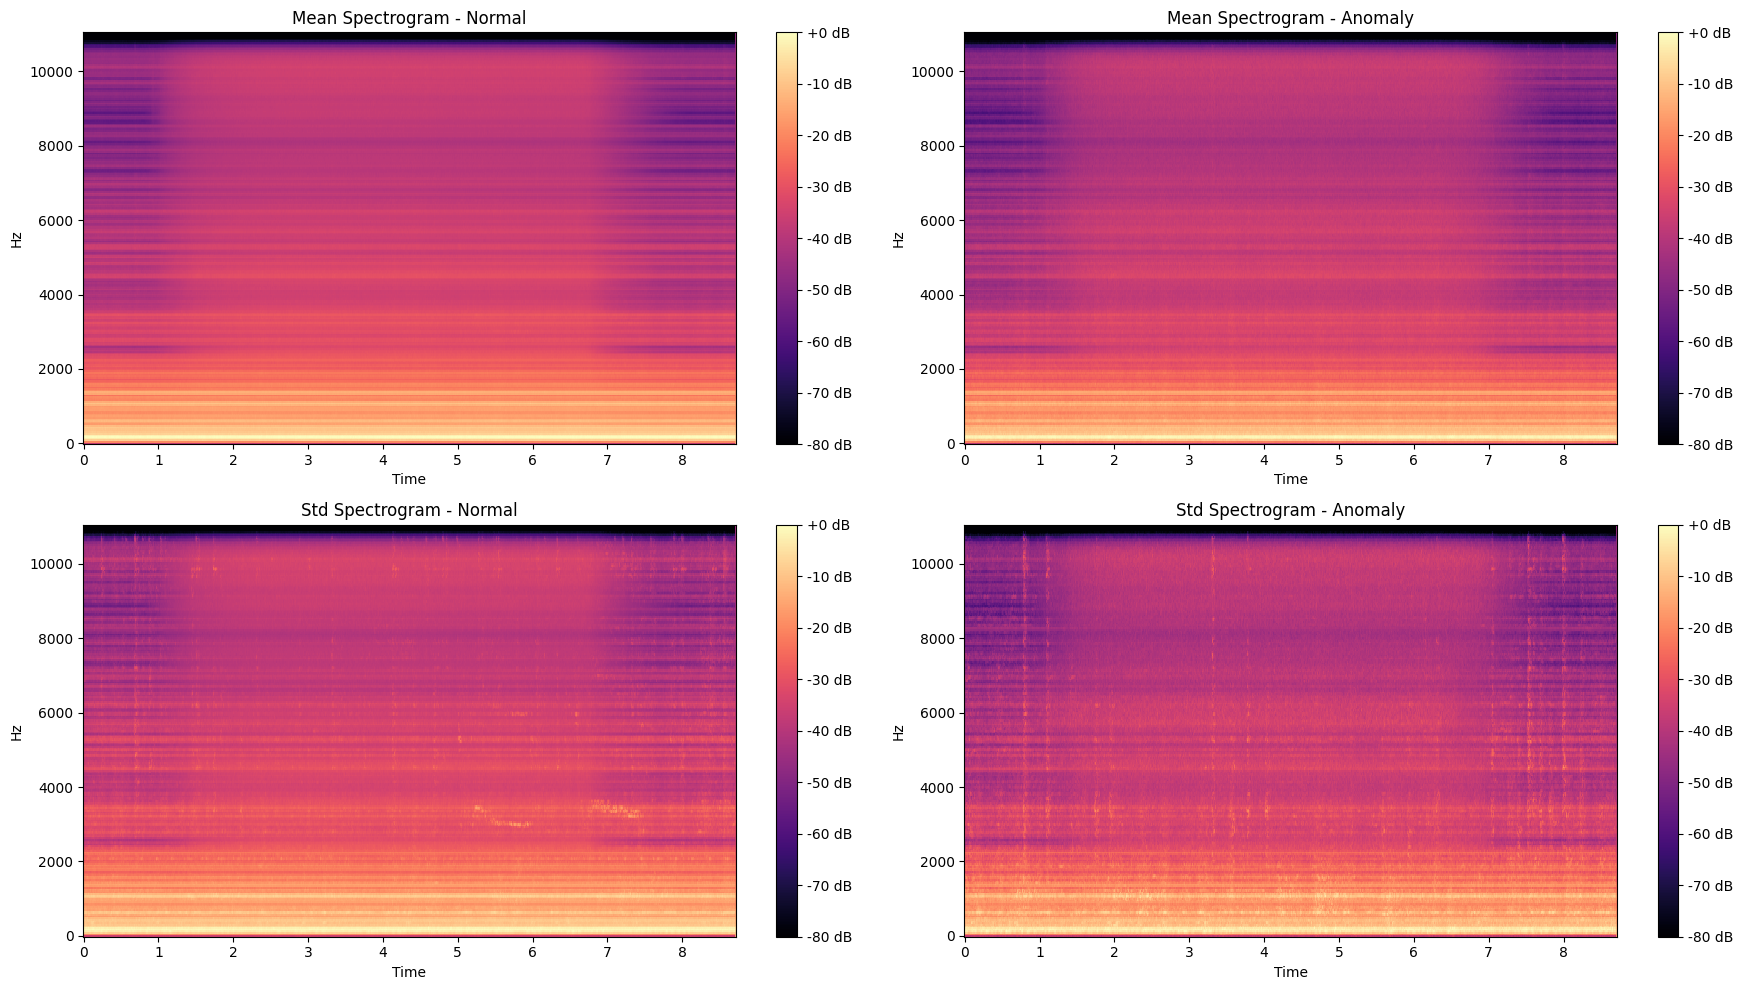

In [23]:
import os
import pandas as pd
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy
import seaborn as sns

# 데이터셋 경로 및 클래스 설정
datasets = "../../datasets/dev"
classes = ["ToyCar", "ToyTrain", "bearing", "fan", "gearbox", "slider", "valve"]

# ToyCar 데이터셋 경로 설정
toycar_dir = os.path.join(datasets, "ToyCar")
attributes_file = os.path.join(toycar_dir, "attributes_00.csv")

# Step 1: ToyCar wav 파일 및 메타데이터 추출
def load_toycar_data(attributes_file):
    df = pd.read_csv(attributes_file)
    
    filenames = df['file_name'].tolist()
    labels = ['anomaly' if 'anomaly' in name else 'normal' for name in filenames]
    
    # 전체 파일 경로 생성
    file_paths = [os.path.join(datasets, f) for f in filenames]
    
    return file_paths, labels

# Step 2: wav 파일을 선형 스펙트로그램으로 변환
def wav_to_linear_spectrogram(file_paths, labels, n_fft=512, hop_length=256, window='hann'):
    spectrograms = []
    valid_labels = []
    for path, label in zip(file_paths, labels):
        if not os.path.isfile(path):
            print(f"파일이 존재하지 않습니다: {path}")
            continue
        try:
            y, sr = librosa.load(path, sr=None)
            S = librosa.stft(y, n_fft=n_fft, hop_length=hop_length, window=window)
            S_mag = np.abs(S)
            spectrograms.append(S_mag)
            valid_labels.append(label)
        except Exception as e:
            print(f"오디오 파일 로드 중 오류 발생: {path}, 오류: {e}")
    return spectrograms, valid_labels

# Step 3: 스펙트로그램 평균 및 표준편차 계산
def calculate_mean_std_spectrograms(spectrograms):
    S_stack = np.stack(spectrograms, axis=0)  # (num_samples, freq_bins, time_frames)
    S_mean = np.mean(S_stack, axis=0)
    S_std = np.std(S_stack, axis=0)
    return S_mean, S_std

# Step 4: 스펙트로그램 평균 및 표준편차 비교 시각화
def plot_spectrogram_comparison(S_mean_normal, S_std_normal, S_mean_anomaly, S_std_anomaly):
    plt.figure(figsize=(18, 10))

    # 정상 데이터 평균 스펙트로그램
    plt.subplot(2, 2, 1)
    librosa.display.specshow(librosa.amplitude_to_db(S_mean_normal, ref=np.max), sr=22050, hop_length=256, x_axis='time', y_axis='linear')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mean Spectrogram - Normal')

    # 이상 데이터 평균 스펙트로그램
    plt.subplot(2, 2, 2)
    librosa.display.specshow(librosa.amplitude_to_db(S_mean_anomaly, ref=np.max), sr=22050, hop_length=256, x_axis='time', y_axis='linear')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mean Spectrogram - Anomaly')

    # 정상 데이터 표준편차 스펙트로그램
    plt.subplot(2, 2, 3)
    librosa.display.specshow(librosa.amplitude_to_db(S_std_normal, ref=np.max), sr=22050, hop_length=256, x_axis='time', y_axis='linear')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Std Spectrogram - Normal')

    # 이상 데이터 표준편차 스펙트로그램
    plt.subplot(2, 2, 4)
    librosa.display.specshow(librosa.amplitude_to_db(S_std_anomaly, ref=np.max), sr=22050, hop_length=256, x_axis='time', y_axis='linear')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Std Spectrogram - Anomaly')

    plt.tight_layout()
    plt.show()


# Step 1: 데이터 로드
file_paths, labels = load_toycar_data(attributes_file)
print(f"Loaded {len(file_paths)} ToyCar audio files.")

# Step 2: wav 파일을 선형 스펙트로그램으로 변환
spectrograms, valid_labels = wav_to_linear_spectrogram(file_paths, labels, hop_length=256)
print(f"Converted {len(spectrograms)} wav files to linear spectrograms.")

# 정상 및 이상 데이터 분리
spectrograms_normal = [S for S, label in zip(spectrograms, valid_labels) if label == 'normal']
spectrograms_anomaly = [S for S, label in zip(spectrograms, valid_labels) if label == 'anomaly']

# Step 3: 평균 및 표준편차 계산
S_mean_normal, S_std_normal = calculate_mean_std_spectrograms(spectrograms_normal)
S_mean_anomaly, S_std_anomaly = calculate_mean_std_spectrograms(spectrograms_anomaly)

# Step 4: 스펙트로그램 평균 및 표준편차 비교 시각화
plot_spectrogram_comparison(S_mean_normal, S_std_normal, S_mean_anomaly, S_std_anomaly)


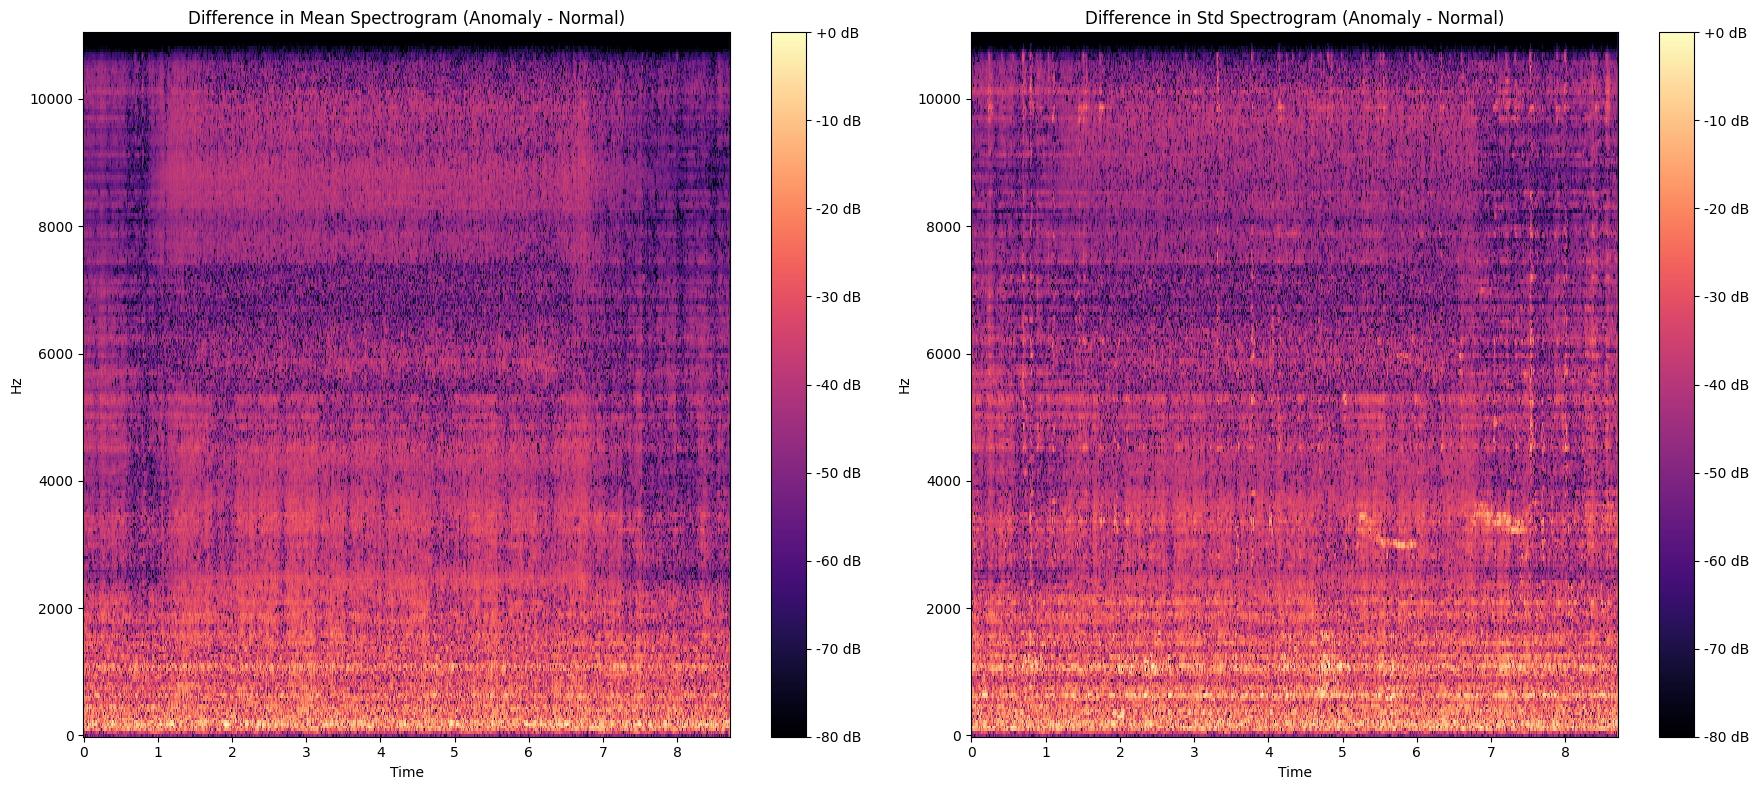

In [25]:
def plot_spectrogram_difference(S_mean_normal, S_std_normal, S_mean_anomaly, S_std_anomaly):
    # 평균 스펙트로그램 차이 계산
    mean_diff = S_mean_anomaly - S_mean_normal
    # 표준편차 스펙트로그램 차이 계산
    std_diff = S_std_anomaly - S_std_normal

    plt.figure(figsize=(18, 8))

    # 평균 스펙트로그램 차이 시각화
    plt.subplot(1, 2, 1)
    librosa.display.specshow(librosa.amplitude_to_db(mean_diff, ref=np.max), sr=22050, hop_length=256, x_axis='time', y_axis='linear')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Difference in Mean Spectrogram (Anomaly - Normal)')

    # 표준편차 스펙트로그램 차이 시각화
    plt.subplot(1, 2, 2)
    librosa.display.specshow(librosa.amplitude_to_db(std_diff, ref=np.max), sr=22050, hop_length=256, x_axis='time', y_axis='linear')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Difference in Std Spectrogram (Anomaly - Normal)')

    plt.tight_layout()
    plt.show()


plot_spectrogram_difference(S_mean_normal, S_std_normal, S_mean_anomaly, S_std_anomaly)